In [ ]:
import import_ipynb
import os
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from utilities.UtilityFunctions import retrieve_reviews_df, retrieve_processed_reviews_df, preprocessing, vectorize, text_preprocess

importing Jupyter notebook from c:\Users\Nick\Documents\GitHub\Group027-Sp22\utilities\UtilityFunctions.ipynb


In [2]:
df = retrieve_processed_reviews_df()
df.head()

Concatenating ../processed_data/processed_data-4.csv
Concatenating ../processed_data/processed_data-5.csv


,Id,Score,Summary,Text,Sentiment,Clean_text
0,127777,5,Most enjoyable....and irresistible,I ordered these to serve at a 'proper Scottish...,1,i serve proper scottish tea church i doubled t...
1,127778,5,You won't even think your eating healthy....,I'm normally a very healthy yet picky eater. ...,1,im normally healthy yet picky eater these soy ...
2,127779,5,The best of all the cheese soy chips,I tested most of the cheddar soy chips availab...,1,i tested cheddar soy chips available online on...
3,127780,5,Low Fat and Few Calories (HEALTHY SNACK); Grea...,Glenny's Low Fat Soy Crisps are a healthy snac...,1,glennys low fat soy crisps healthy snack i abs...
4,127781,2,overcooked,Glennys organic soy crisps have always been my...,-1,glennys organic soy crisps always favorite bra...


In [3]:
X = df['Clean_text']
y = df['Sentiment']
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=42)

In [4]:
X_train_counts, X_train_tfidf = vectorize(X_train)

X_train_tfidf.shape

(454741, 290983)

In [5]:
clf_logReg_pipe = Pipeline([("vect", CountVectorizer()), ("tfidf", TfidfTransformer()), 
                            ("clf_logReg", LogisticRegression(multi_class='multinomial',solver ='newton-cg'))])
                            
clf_logReg_pipe.fit(X_train, y_train)

Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf_logReg',
                 LogisticRegression(multi_class='multinomial',
                                    solver='newton-cg'))])

In [6]:
predictedLogReg = clf_logReg_pipe.predict(X_test)
np.mean(predictedLogReg == y_test)

0.8051035307777563

In [7]:
#testing change
df

,Id,Score,Summary,Text,Sentiment,Clean_text
0,127777,5,Most enjoyable....and irresistible,I ordered these to serve at a 'proper Scottish...,1,i serve proper scottish tea church i doubled t...
1,127778,5,You won't even think your eating healthy....,I'm normally a very healthy yet picky eater. ...,1,im normally healthy yet picky eater these soy ...
2,127779,5,The best of all the cheese soy chips,I tested most of the cheddar soy chips availab...,1,i tested cheddar soy chips available online on...
3,127780,5,Low Fat and Few Calories (HEALTHY SNACK); Grea...,Glenny's Low Fat Soy Crisps are a healthy snac...,1,glennys low fat soy crisps healthy snack i abs...
4,127781,2,overcooked,Glennys organic soy crisps have always been my...,-1,glennys organic soy crisps always favorite bra...
...,...,...,...,...,...,...
568422,568450,5,Will not do without,Great for sesame chicken..this is a good if no...,1,great sesame chickenthis good better resturant...
568423,568451,2,disappointed,I'm disappointed with the flavor. The chocolat...,-1,im disappointed flavor the chocolate notes esp...
568424,568452,5,Perfect for our maltipoo,"These stars are small, so you can give 10-15 o...",1,these stars small give 1015 one training sessi...
568425,568453,5,Favorite Training and reward treat,These are the BEST treats for training and rew...,1,these best treats training rewarding good groo...


In [8]:
from sklearn.model_selection import StratifiedShuffleSplit

data = df

print("Before {}".format(len(data)))
dataAfter = data.dropna(subset=["Score"]) # removes all NAN in reviews.rating
print("After {}".format(len(dataAfter)))
dataAfter["Score"] = dataAfter["Score"].astype(int)

split = StratifiedShuffleSplit(n_splits=5, test_size=0.2)
for train_index, test_index in split.split(dataAfter, dataAfter["Score"]): 
    strat_train = dataAfter.reindex(train_index)
    strat_test = dataAfter.reindex(test_index)

Before 568427
After 568427


In [9]:
def sentiments(rating):
    if (rating == 5) or (rating == 4):
        return "Positive"
    elif rating == 3:
        return "Neutral"
    elif (rating == 2) or (rating == 1):
        return "Negative"
# Add sentiments to the data
strat_train["Sentiment"] = strat_train["Score"].apply(sentiments)
strat_test["Sentiment"] = strat_test["Score"].apply(sentiments)
strat_train["Sentiment"][:20]

116681    Positive
180571    Positive
205298    Positive
386898    Positive
263185    Positive
490704    Negative
471833    Positive
271241    Positive
547569    Positive
41009      Neutral
89938     Positive
476285    Positive
95188     Positive
151192    Positive
498124    Positive
361667    Positive
325413    Negative
386797    Positive
368054    Positive
314397    Positive
Name: Sentiment, dtype: object

In [13]:
# Prepare data
X_train = strat_train["Clean_text"]
y_train = strat_train["Sentiment"]
X_test = strat_test["Clean_text"]
y_test = strat_test["Sentiment"]
print(len(X_train), len(y_train), '\n', len(X_test), len(y_test))

# Replace "nan" with space
X_train = X_train.fillna(' ')
X_test = X_test.fillna(' ')
y_train = y_train.fillna(' ')
y_test = y_test.fillna(' ')

# Text preprocessing and occurance counting
from sklearn.feature_extraction.text import CountVectorizer 
count_vect = CountVectorizer()
#X_train_counts = count_vect.fit_transform(X_train) 

X_train_counts, X_train_tfidf = vectorize(X_train)
X_train_counts.shape

454741 454741 
 113686 113686


(454741, 290799)

In [14]:
from sklearn.feature_extraction.text import TfidfTransformer
tfidf_transformer = TfidfTransformer(use_idf=False)
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
X_train_tfidf.shape

(454741, 290799)

In [16]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
clf_logReg_pipe = Pipeline([("vect", CountVectorizer()), ("tfidf", TfidfTransformer()), ("clf_logReg", LogisticRegression(multi_class='multinomial',solver ='newton-cg'))])
clf_logReg_pipe.fit(X_train, y_train)

predictedLogReg = clf_logReg_pipe.predict(X_test)
np.mean(predictedLogReg == y_test)

#clf_logReg_pipe = Pipeline([("vect", CountVectorizer()), ("tfidf", TfidfTransformer()), 
#                            ("clf_logReg", LogisticRegression(multi_class='multinomial',solver ='newton-cg'))])
                            
#clf_logReg_pipe.fit(X_train, y_train)

0.8822194465457488

In [19]:
clf_logReg_pipe.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'vect', 'tfidf', 'clf_logReg', 'vect__analyzer', 'vect__binary', 'vect__decode_error', 'vect__dtype', 'vect__encoding', 'vect__input', 'vect__lowercase', 'vect__max_df', 'vect__max_features', 'vect__min_df', 'vect__ngram_range', 'vect__preprocessor', 'vect__stop_words', 'vect__strip_accents', 'vect__token_pattern', 'vect__tokenizer', 'vect__vocabulary', 'tfidf__norm', 'tfidf__smooth_idf', 'tfidf__sublinear_tf', 'tfidf__use_idf', 'clf_logReg__C', 'clf_logReg__class_weight', 'clf_logReg__dual', 'clf_logReg__fit_intercept', 'clf_logReg__intercept_scaling', 'clf_logReg__l1_ratio', 'clf_logReg__max_iter', 'clf_logReg__multi_class', 'clf_logReg__n_jobs', 'clf_logReg__penalty', 'clf_logReg__random_state', 'clf_logReg__solver', 'clf_logReg__tol', 'clf_logReg__verbose', 'clf_logReg__warm_start'])

In [20]:
param_grid = {
    
    "clf_logReg__C": [0.01, 0.5, 10],

}

grid_pipeline = GridSearchCV(clf_logReg_pipe, param_grid = param_grid)
grid_pipeline.fit(X_train, y_train)
grid_pipeline.best_params_


{'clf_logReg__C': 10}

In [22]:
grid_pipeline.cv_results_

{'mean_fit_time': array([ 59.84163933, 105.08221521, 215.63259168]),
 'std_fit_time': array([ 4.06355679,  7.32966529, 14.38335304]),
 'mean_score_time': array([4.89311767, 4.69323139, 5.23002033]),
 'std_score_time': array([0.32625993, 0.10658637, 0.39305681]),
 'param_clf_logReg__C': masked_array(data=[0.01, 0.5, 10],
              mask=[False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'clf_logReg__C': 0.01},
  {'clf_logReg__C': 0.5},
  {'clf_logReg__C': 10}],
 'split0_test_score': array([0.80960758, 0.87488593, 0.89208238]),
 'split1_test_score': array([0.80970445, 0.87403791, 0.89138849]),
 'split2_test_score': array([0.80918767, 0.87332322, 0.89054185]),
 'split3_test_score': array([0.80867089, 0.87443374, 0.89166337]),
 'split4_test_score': array([0.80881383, 0.87300435, 0.89027796]),
 'mean_test_score': array([0.80919688, 0.87393703, 0.89119081]),
 'std_test_score': array([0.00041226, 0.00069339, 0.00067996]),
 'rank_test_score': array([3, 2

Text(0.5, 1.0, 'All C values together')

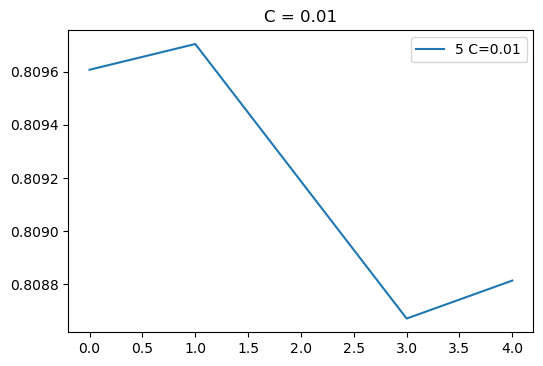

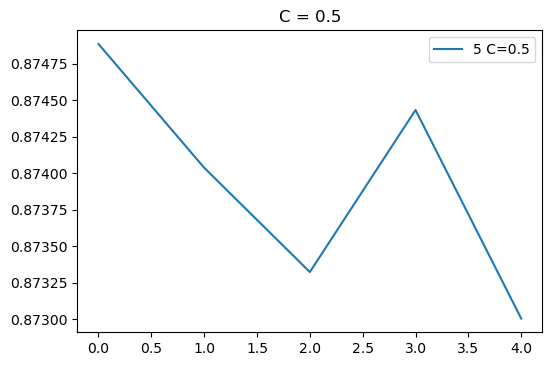

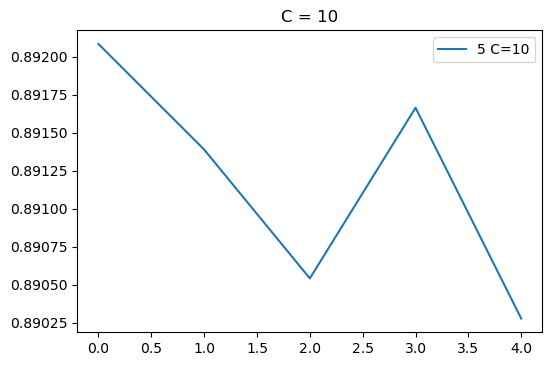

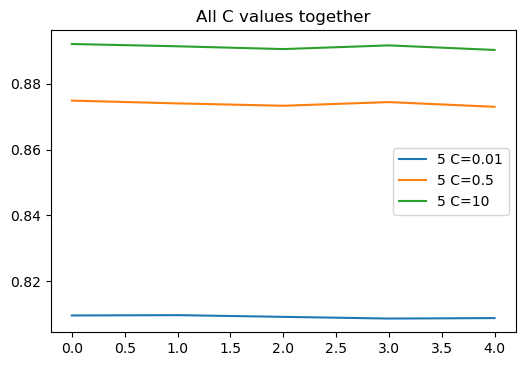

In [26]:
def create_mat(clf):
    clf_keys = sorted(clf.cv_results_.keys())
    clf_mat = np.zeros((5, 3))
    i = 0
    #for key in sorted(clf.cv_results_)[6:31]:
    for i in range(5):
        clf_mat[i] = clf.cv_results_[f"split{i}_test_score"]
        i += 1
    return clf_mat


clf_mat = create_mat(grid_pipeline)

# Plotting C = 0.01
plt.figure(dpi = 100)
plt.plot(range(5), clf_mat[:,0], label = "5 C=0.01")
plt.legend()
plt.title("C = 0.01")

# Plotting C = 0.5
plt.figure(dpi = 100)
plt.plot(range(5), clf_mat[:,1], label = "5 C=0.5")
plt.legend()
plt.title("C = 0.5")

# Plotting C = 10
plt.figure(dpi = 100)
plt.plot(range(5), clf_mat[:,2], label = "5 C=10")
plt.legend()
plt.title("C = 10")

# Plot Altogether
plt.figure(dpi = 100)
plt.plot(range(5), clf_mat[:,0], label = "5 C=0.01")
plt.plot(range(5), clf_mat[:,1], label = "5 C=0.5")
plt.plot(range(5), clf_mat[:,2], label = "5 C=10")
plt.legend()
plt.title("All C values together")

With C = 0.01, the generalization estimate/test score seems to be around the range (0.80, 0.81). With C = 0.5, we observe a much higher test accuracy, ranging around 0.873 to 0.875. With C = 10, we observe the best test accuracy (and thus highest generalization estimate), which ranges from about 0.890 to 0.892. In the original pipeline, LogisticRegression uses the default C value of 1.0, and achieves a test accuracy of 0.882. Thus, the best C value (regularization parameter) for our model is C = 10.

In [27]:
# Rerun model with new chosen hyperparameter
clf_logReg_pipe = Pipeline([("vect", CountVectorizer()), ("tfidf", TfidfTransformer()), ("clf_logReg", LogisticRegression(multi_class='multinomial',solver ='newton-cg', C=10))])
clf_logReg_pipe.fit(X_train, y_train)

predictedLogReg = clf_logReg_pipe.predict(X_test)
np.mean(predictedLogReg == y_test)

0.8932674207905986